In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Dữ liệu chuỗi nhiễu đơn giản
np.random.seed(42)
n = 200
true_values = np.cumsum(np.random.randn(n))         # Chuỗi gốc
observations = true_values + np.random.normal(0, 2, n)  # Thêm nhiễu

In [2]:
def kalman_filter(zs, F, H, Q, R, x_init, P_init):
    n = len(zs)
    x_dim = len(x_init)
    
    x_estimates = np.zeros((n, x_dim))
    x = x_init
    P = P_init
    
    for i in range(n):
        # === DỰ ĐOÁN ===
        x_pred = F @ x
        P_pred = F @ P @ F.T + Q

        # === CẬP NHẬT ===
        z = zs[i]
        y = z - (H @ x_pred)  # Innovation
        S = H @ P_pred @ H.T + R
        K = P_pred @ H.T @ np.linalg.inv(S)
        
        x = x_pred + K @ y
        P = (np.eye(x_dim) - K @ H) @ P_pred
        
        x_estimates[i] = x.ravel()

    return x_estimates


In [3]:
def simple_hmm_predict(observations, means, variances, trans_mat, init_probs):
    n = len(observations)
    n_states = len(means)
    state_seq = np.zeros(n, dtype=int)

    probs = np.copy(init_probs)
    
    for t in range(n):
        obs = observations[t]
        # Xác suất quan sát trong từng trạng thái
        likelihoods = np.array([
            (1 / np.sqrt(2 * np.pi * var)) * np.exp(-0.5 * ((obs - mean)**2 / var))
            for mean, var in zip(means, variances)
        ])
        # Cập nhật xác suất trạng thái
        probs = probs * likelihoods
        probs = probs / np.sum(probs)  # Chuẩn hóa
        
        # Dự đoán trạng thái
        state = np.argmax(probs)
        state_seq[t] = state
        
        # Chuyển sang bước tiếp theo
        probs = trans_mat[state]
    
    return state_seq


In [4]:
# Tham số Kalman
F = np.array([[1, 1], [0, 1]])
H = np.array([[1, 0]])
Q = np.array([[1e-3, 0], [0, 1e-3]])
R = np.array([[4]])  # Nhiễu đo
x0 = np.array([[0], [0]])
P0 = np.eye(2) * 1000

# Chạy Kalman
kalman_result = kalman_filter(observations, F, H, Q, R, x0, P0)
kalman_positions = kalman_result[:, 0]

In [5]:
# HMM với 2 trạng thái: 1 yên tĩnh, 1 dao động
means = [0, 0]
variances = [1, 10]  # Trạng thái 1 ít nhiễu, trạng thái 2 nhiều nhiễu
trans_mat = np.array([
    [0.9, 0.1],
    [0.2, 0.8]
])
init_probs = np.array([0.5, 0.5])

state_seq = simple_hmm_predict(observations, means, variances, trans_mat, init_probs)


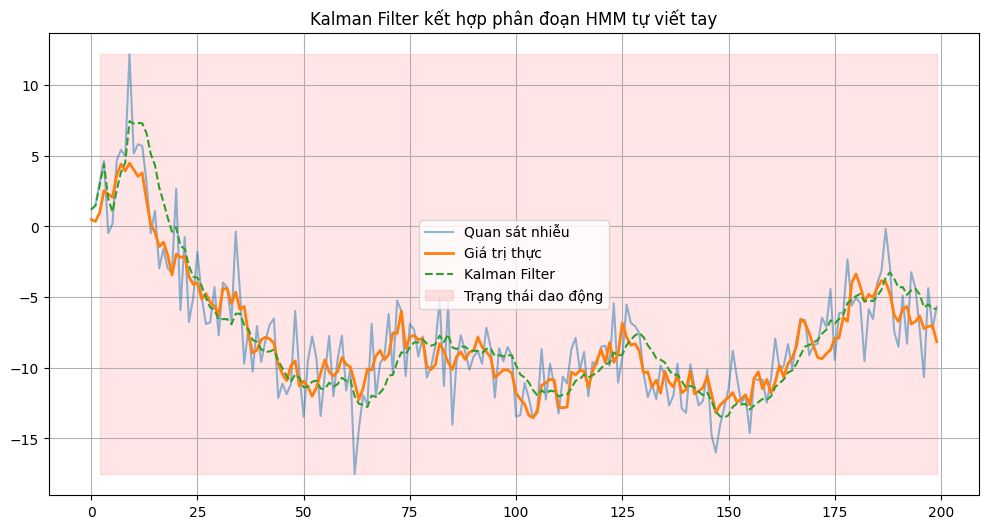

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(observations, label="Quan sát nhiễu", alpha=0.5)
plt.plot(true_values, label="Giá trị thực", linewidth=2)
plt.plot(kalman_positions, label="Kalman Filter", linestyle="--")

plt.fill_between(range(len(state_seq)), min(observations),
                 max(observations),
                 where=state_seq == 1, color='red', alpha=0.1, label='Trạng thái dao động')

plt.title("Kalman Filter kết hợp phân đoạn HMM tự viết tay")
plt.legend()
plt.grid(True)
plt.show()
